In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [2]:
# %% Function to preprocess images for MobileNetV2
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None
    try:
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to (224, 224) as MobileNetV2 expects 224x224 images
        image_resized = cv2.resize(image_rgb, (224, 224))

        # Convert to numpy array and preprocess for MobileNetV2
        image_array = np.array(image_resized, dtype=np.float32)
        image_preprocessed = preprocess_input(image_array)

        # Expand dimensions to match model input
        image_expanded = np.expand_dims(image_preprocessed, axis=0)

        return image_expanded, image_rgb
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [3]:
# %% Function to prepare data for the top 50 classes
def prepare_data(image_folder, csv_file, top_classes):
    df = pd.read_csv(csv_file)
    unique_medicines = {}  # Medicine name to class index mapping
    current_index = 0      # Start indexing from 0

    images = []
    labels = []
    medicine_mappings = []

    for idx, row in df.iterrows():
        medicine_name = row['MEDICINE_NAME']
        image_name = row['IMAGE']

        if medicine_name in top_classes and medicine_name not in unique_medicines:
            unique_medicines[medicine_name] = current_index
            current_index += 1

        if medicine_name not in unique_medicines:
            continue

        medicine_index = unique_medicines[medicine_name]
        image_path = os.path.join(image_folder, image_name)

        medicine_mappings.append((medicine_name, medicine_index))

        if os.path.exists(image_path):
            # Preprocess the image
            image_expanded, _ = preprocess_image(image_path)
            if image_expanded is None:
                print(f"Skipping image due to preprocessing error: {image_path}")
                continue
            image_processed = image_expanded.squeeze()

            images.append(image_processed)
            labels.append(medicine_index)
        else:
            print(f"Image not found: {image_path}")

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels, unique_medicines, medicine_mappings

In [ ]:
# %% Load the top classes (from your accuracy data)
top_classes = [
    'Rivotril', 'Lumona', 'Lucan-R', 'Maxima', 'Ritch', 'Filmet', 'Dinafex', 'Etizin',
    'Sergel', 'Napa Extend', 'Monas', 'Fexo', 'Opton', 'Denixil', 'Ketozol', 'Tamen',
    'Telfast', 'Fenadin', 'Odmon', 'Metsina', 'Esoral', 'Omastin', 'Zithrin', 'Provair',
    'Ketotab', 'Fexofast', 'Rhinil', 'Exium', 'Flexibac', 'Progut', 'Nizoder', 'Flugal',
    'Disopan', 'Esonix', 'Trilock', 'Montair', 'Flexilax', 'M-Kast', 'Nexcap', 'Flamyd',
    'Nidazyl', 'Rozith', 'Maxpro', 'Montene', 'Diflu', 'Vifas', 'Montex', 'Ketoral',
    'Romycin', 'Fixal', 'Aceta'
]

# %% Prepare data for the 50 top classes
image_folder = 'combined_images'  # Update with your image folder path
csv_file = 'combined_labels.csv'  # Update with your CSV file path

images, labels, unique_medicines, medicine_mappings = prepare_data(image_folder, csv_file, top_classes)

In [5]:
# One-hot encode labels
num_classes = len(unique_medicines)
labels_categorical = to_categorical(labels, num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_categorical, test_size=0.2, random_state=42
)

In [6]:
from tensorflow.keras.models import Model

def create_vgg16_model(input_shape, num_classes):
    # Load the pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    x = base_model.output
    x = Flatten()(x)  # Flatten the 3D tensor to 1D

    # First fully connected (Dense) layer
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization layer

    # Add Dropout for regularization
    x = Dropout(0.5)(x)

    # Second fully connected (Dense) layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)

    # Add another Dropout layer for regularization
    x = Dropout(0.5)(x)

    # Final prediction layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [7]:
from sklearn.model_selection import KFold

# Number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics for each fold
fold_results = []


In [8]:
# %% Function to predict multiple images
def predict_multiple_images(image_paths, model, unique_medicines):
    index_to_medicine = {index: name for name, index in unique_medicines.items()}

    for image_path in image_paths:
        if os.path.exists(image_path):
            image_input, image_original = preprocess_image(image_path)
            if image_input is None:
                print(f"Skipping image due to preprocessing error: {image_path}")
                continue

            prediction = model.predict(image_input)
            predicted_index = np.argmax(prediction)
            confidence = np.max(prediction)

            medicine_name = index_to_medicine.get(predicted_index, "Unknown")

            print(f"\nImage: {os.path.basename(image_path)}")
            print(f"Predicted Class Index: {predicted_index}")
            print(f"Predicted Medicine Name: {medicine_name}")
            print(f"Confidence: {confidence*100:.2f}%")

            # Display the original image with prediction
            plt.figure(figsize=(4,4))
            plt.imshow(image_original)
            plt.title(f"Predicted: {medicine_name} ({confidence*100:.2f}%)", fontsize=12)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image not found: {image_path}")

In [9]:
# %% Function to predict multiple images
def predict_multiple_images(image_paths, model, unique_medicines):
    index_to_medicine = {index: name for name, index in unique_medicines.items()}

    for image_path in image_paths:
        if os.path.exists(image_path):
            image_input, image_original = preprocess_image(image_path)
            if image_input is None:
                print(f"Skipping image due to preprocessing error: {image_path}")
                continue

            prediction = model.predict(image_input)
            predicted_index = np.argmax(prediction)
            confidence = np.max(prediction)

            medicine_name = index_to_medicine.get(predicted_index, "Unknown")

            print(f"\nImage: {os.path.basename(image_path)}")
            print(f"Predicted Class Index: {predicted_index}")
            print(f"Predicted Medicine Name: {medicine_name}")
            print(f"Confidence: {confidence*100:.2f}%")

            # Display the original image with prediction
            plt.figure(figsize=(4,4))
            plt.imshow(image_original)
            plt.title(f"Predicted: {medicine_name} ({confidence*100:.2f}%)", fontsize=12)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image not found: {image_path}")

In [10]:
# %% Function to predict multiple images
def predict_multiple_images(image_paths, model, unique_medicines):
    index_to_medicine = {index: name for name, index in unique_medicines.items()}

    for image_path in image_paths:
        if os.path.exists(image_path):
            image_input, image_original = preprocess_image(image_path)
            if image_input is None:
                print(f"Skipping image due to preprocessing error: {image_path}")
                continue

            prediction = model.predict(image_input)
            predicted_index = np.argmax(prediction)
            confidence = np.max(prediction)

            medicine_name = index_to_medicine.get(predicted_index, "Unknown")

            print(f"\nImage: {os.path.basename(image_path)}")
            print(f"Predicted Class Index: {predicted_index}")
            print(f"Predicted Medicine Name: {medicine_name}")
            print(f"Confidence: {confidence*100:.2f}%")

            # Display the original image with prediction
            plt.figure(figsize=(4,4))
            plt.imshow(image_original)
            plt.title(f"Predicted: {medicine_name} ({confidence*100:.2f}%)", fontsize=12)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image not found: {image_path}")

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# %% Plot accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [12]:
# %% Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
# %% Per-class accuracy
def calculate_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    class_accuracy_dict = dict(zip(class_names, per_class_accuracy))
    sorted_class_accuracy = dict(sorted(class_accuracy_dict.items(), key=lambda x: x[1], reverse=True))

    print("\nPer-Class Accuracy:")
    for class_name, acc in sorted_class_accuracy.items():
        print(f"{class_name}: {acc * 100:.2f}%")

In [14]:
# %% Evaluate on validation data
def evaluate_model(model, X_val, y_val, class_names):
    # Predict on validation data
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    # Plot accuracy and loss
    plot_training_history(history)

    # Plot confusion matrix
    plot_confusion_matrix(y_val_true, y_val_pred, class_names)

    # Calculate per-class accuracy
    calculate_class_accuracy(y_val_true, y_val_pred, class_names)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val_true, y_val_pred, target_names=class_names))


Starting Fold 1/5...
Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.1654 - loss: 4.0008 - val_accuracy: 0.2255 - val_loss: 3.9405
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.5690 - loss: 1.6303 - val_accuracy: 0.6258 - val_loss: 1.3791
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.7819 - loss: 0.8597 - val_accuracy: 0.8595 - val_loss: 0.6306
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8821 - loss: 0.4971 - val_accuracy: 0.8807 - val_loss: 0.5248
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9446 - loss: 0.3083 - val_accuracy: 0.9069 - val_loss: 0.3894
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9610 - loss: 0.1947 - val_accuracy: 0.9150 - val_loss: 0.3377
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9721 - loss: 0.1461 - val_accuracy: 0.9183 - val_loss: 0.3381
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.9797 - loss: 0.1215 - va

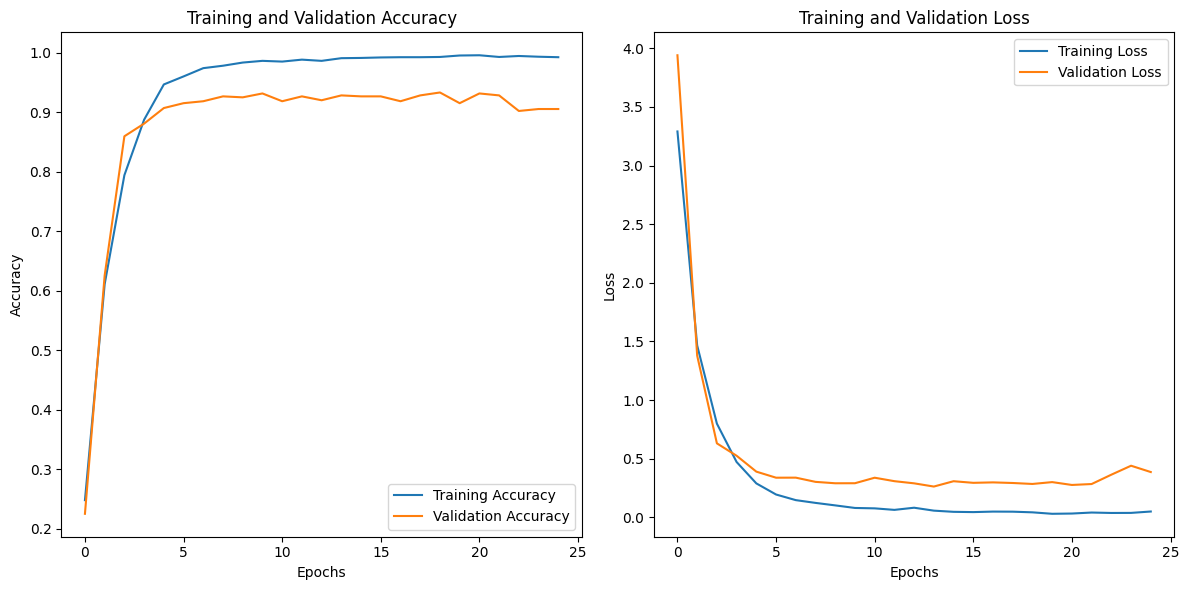

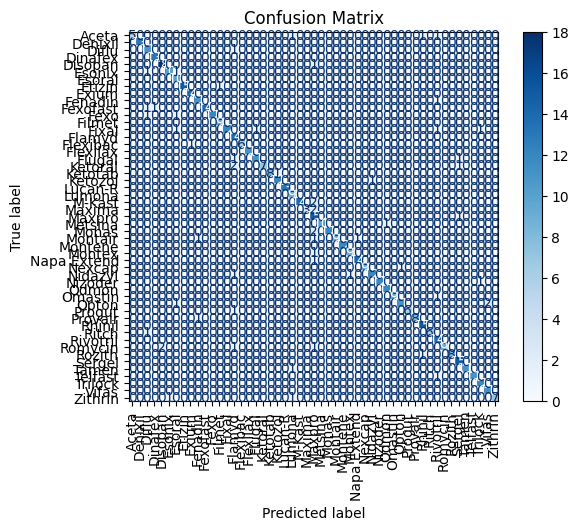


Per-Class Accuracy:
Denixil: 100.00%
Dinafex: 100.00%
Esoral: 100.00%
Exium: 100.00%
Filmet: 100.00%
Flamyd: 100.00%
Flexilax: 100.00%
Lucan-R: 100.00%
Lumona: 100.00%
Montene: 100.00%
Odmon: 100.00%
Rhinil: 100.00%
Rivotril: 100.00%
Sergel: 100.00%
Trilock: 100.00%
Vifas: 100.00%
Disopan: 94.74%
Etizin: 93.75%
Maxpro: 93.75%
Napa Extend: 93.33%
Ketozol: 92.31%
Nizoder: 92.31%
Diflu: 91.67%
Fenadin: 91.67%
Tamen: 91.67%
Telfast: 91.67%
Metsina: 90.91%
Montex: 90.00%
Nexcap: 90.00%
Omastin: 90.00%
Ketotab: 88.89%
Provair: 88.89%
Rozith: 88.89%
Fexofast: 87.50%
M-Kast: 87.50%
Fexo: 85.71%
Flexibac: 85.71%
Monas: 85.71%
Nidazyl: 85.71%
Progut: 85.71%
Ritch: 85.71%
Flugal: 84.62%
Esonix: 83.33%
Opton: 78.57%
Zithrin: 77.78%
Fixal: 75.00%
Montair: 75.00%
Ketoral: 70.00%
Romycin: 69.23%
Aceta: 62.50%
Maxima: 60.00%

Classification Report:
              precision    recall  f1-score   support

       Aceta       1.00      0.62      0.77         8
     Denixil       1.00      1.00      1.00  

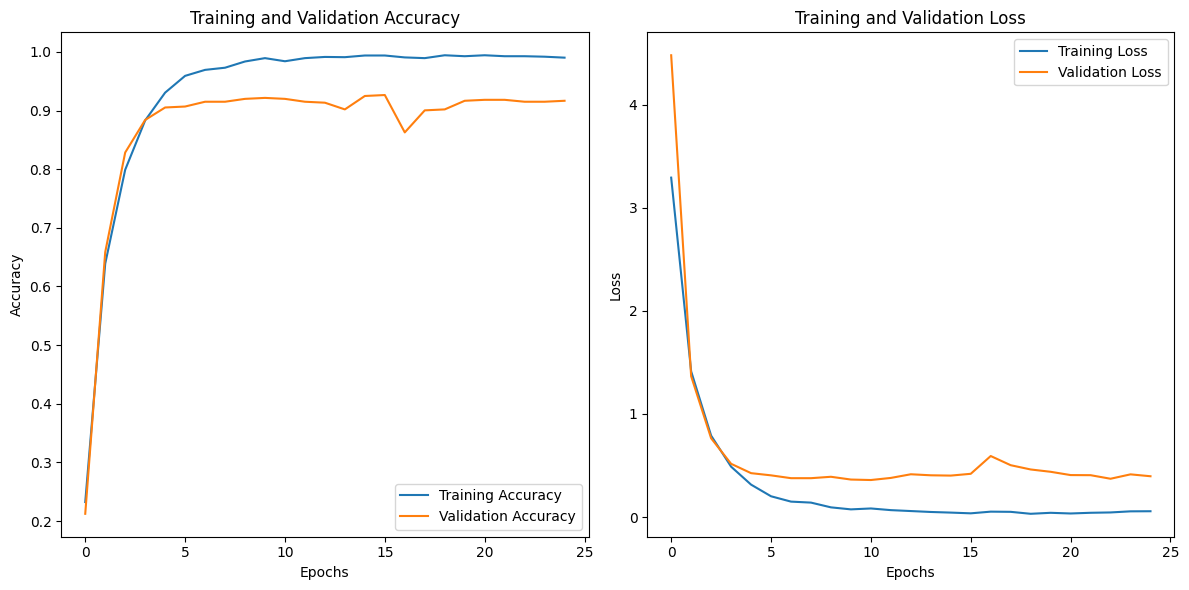

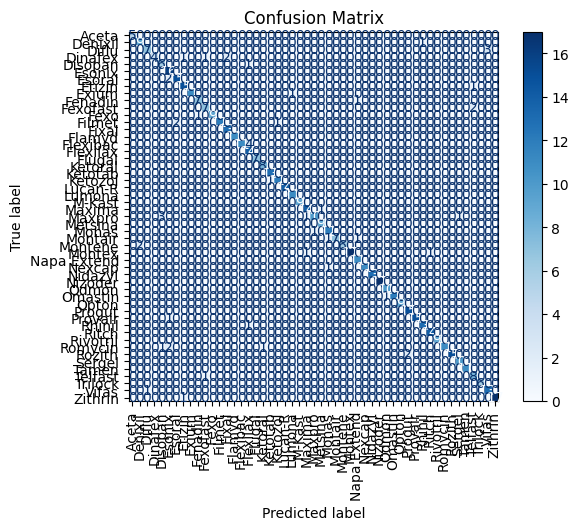


Per-Class Accuracy:
Aceta: 100.00%
Esonix: 100.00%
Fixal: 100.00%
Flamyd: 100.00%
Flexilax: 100.00%
Flugal: 100.00%
Ketoral: 100.00%
Ketotab: 100.00%
Lucan-R: 100.00%
Lumona: 100.00%
M-Kast: 100.00%
Metsina: 100.00%
Napa Extend: 100.00%
Nidazyl: 100.00%
Nizoder: 100.00%
Odmon: 100.00%
Opton: 100.00%
Progut: 100.00%
Ritch: 100.00%
Rivotril: 100.00%
Sergel: 100.00%
Tamen: 100.00%
Trilock: 100.00%
Zithrin: 94.44%
Etizin: 93.75%
Provair: 93.75%
Maxima: 93.33%
Rhinil: 92.86%
Vifas: 92.86%
Ketozol: 92.31%
Monas: 92.31%
Omastin: 92.31%
Exium: 91.67%
Nexcap: 91.67%
Denixil: 90.00%
Fexo: 90.00%
Montex: 89.47%
Telfast: 88.89%
Esoral: 88.24%
Rozith: 88.24%
Fenadin: 87.50%
Disopan: 85.71%
Filmet: 80.00%
Fexofast: 77.78%
Montair: 77.78%
Montene: 75.00%
Flexibac: 73.33%
Romycin: 73.33%
Diflu: 70.00%
Maxpro: 66.67%
Dinafex: 50.00%

Classification Report:
              precision    recall  f1-score   support

       Aceta       1.00      1.00      1.00         5
     Denixil       0.82      0.90     

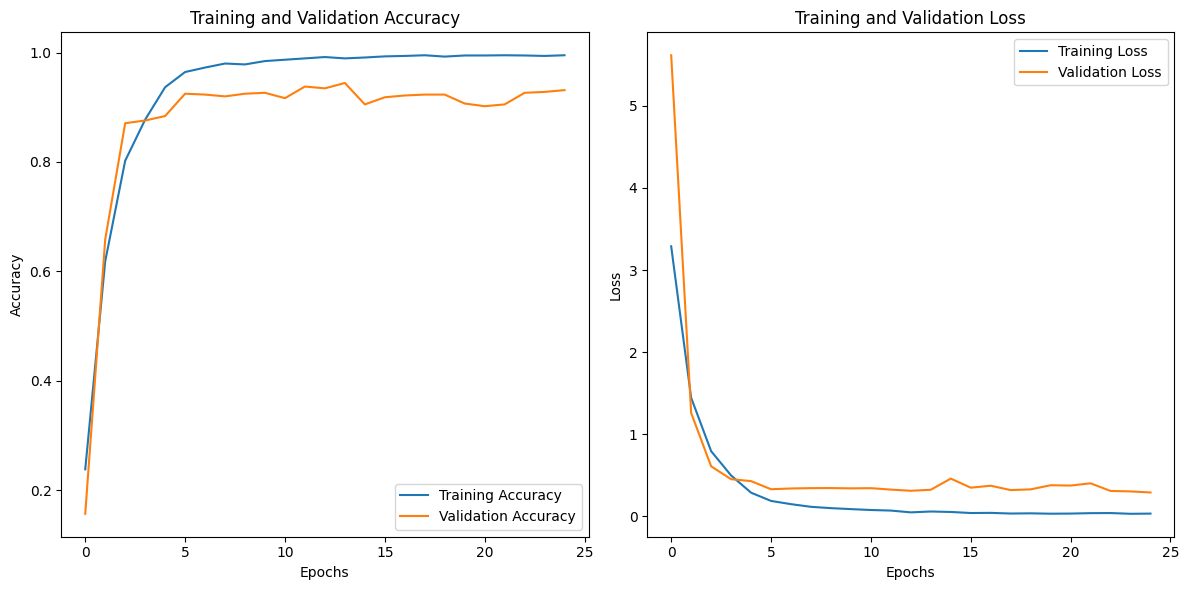

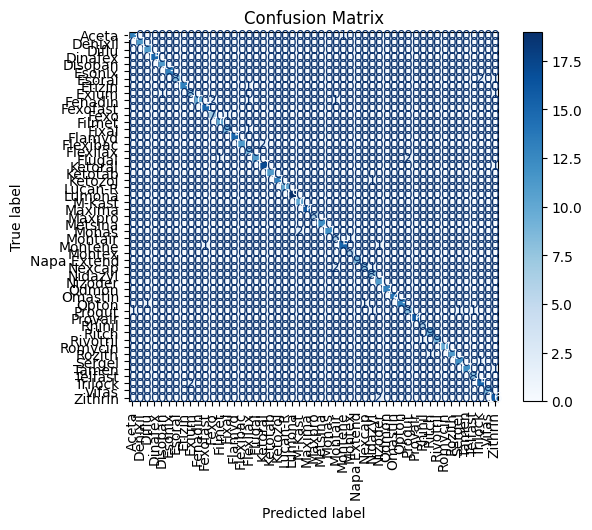


Per-Class Accuracy:
Denixil: 100.00%
Diflu: 100.00%
Dinafex: 100.00%
Disopan: 100.00%
Esonix: 100.00%
Fexofast: 100.00%
Filmet: 100.00%
Flamyd: 100.00%
Flexilax: 100.00%
Ketotab: 100.00%
Lucan-R: 100.00%
Lumona: 100.00%
M-Kast: 100.00%
Maxima: 100.00%
Maxpro: 100.00%
Metsina: 100.00%
Montex: 100.00%
Napa Extend: 100.00%
Nidazyl: 100.00%
Nizoder: 100.00%
Odmon: 100.00%
Omastin: 100.00%
Provair: 100.00%
Rhinil: 100.00%
Ritch: 100.00%
Romycin: 100.00%
Telfast: 100.00%
Vifas: 100.00%
Ketoral: 94.44%
Aceta: 92.86%
Etizin: 92.86%
Ketozol: 92.86%
Sergel: 92.31%
Tamen: 92.31%
Rozith: 91.67%
Fixal: 90.00%
Rivotril: 90.00%
Zithrin: 88.89%
Montene: 88.24%
Trilock: 88.24%
Fexo: 87.50%
Opton: 86.67%
Monas: 85.71%
Montair: 85.71%
Flexibac: 84.62%
Exium: 80.00%
Flugal: 78.57%
Esoral: 72.73%
Nexcap: 72.73%
Fenadin: 71.43%
Progut: 66.67%

Classification Report:
              precision    recall  f1-score   support

       Aceta       0.93      0.93      0.93        14
     Denixil       1.00      1.00

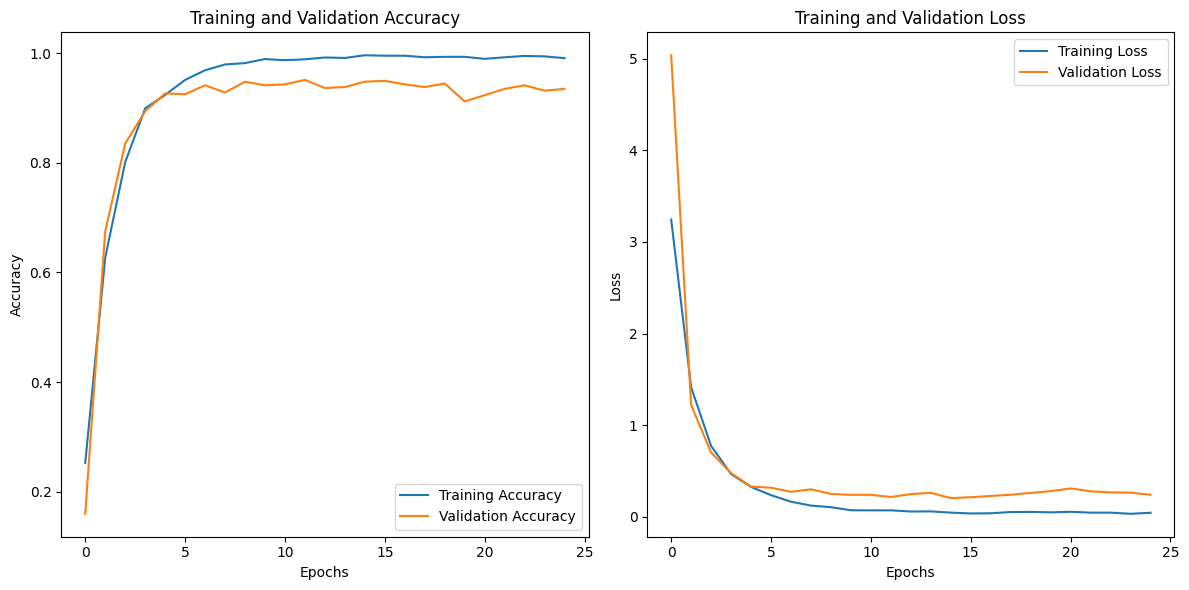

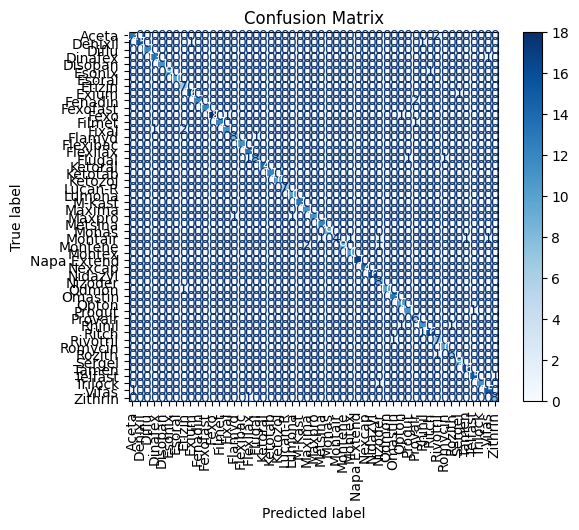


Per-Class Accuracy:
Diflu: 100.00%
Disopan: 100.00%
Esoral: 100.00%
Etizin: 100.00%
Fexofast: 100.00%
Flexibac: 100.00%
Flexilax: 100.00%
Ketoral: 100.00%
Ketotab: 100.00%
Ketozol: 100.00%
Lucan-R: 100.00%
Lumona: 100.00%
M-Kast: 100.00%
Maxima: 100.00%
Metsina: 100.00%
Monas: 100.00%
Montex: 100.00%
Napa Extend: 100.00%
Nexcap: 100.00%
Nidazyl: 100.00%
Nizoder: 100.00%
Omastin: 100.00%
Opton: 100.00%
Provair: 100.00%
Romycin: 100.00%
Sergel: 100.00%
Tamen: 100.00%
Exium: 94.12%
Ritch: 94.12%
Telfast: 93.75%
Vifas: 93.75%
Dinafex: 92.86%
Filmet: 92.31%
Progut: 91.67%
Trilock: 91.67%
Odmon: 90.91%
Esonix: 90.00%
Fexo: 90.00%
Flamyd: 88.89%
Zithrin: 88.89%
Denixil: 88.24%
Rivotril: 87.50%
Aceta: 86.67%
Fenadin: 85.71%
Rozith: 85.71%
Maxpro: 84.62%
Rhinil: 84.62%
Fixal: 78.57%
Montene: 75.00%
Flugal: 72.73%
Montair: 44.44%

Classification Report:
              precision    recall  f1-score   support

       Aceta       0.93      0.87      0.90        15
     Denixil       1.00      0.88 

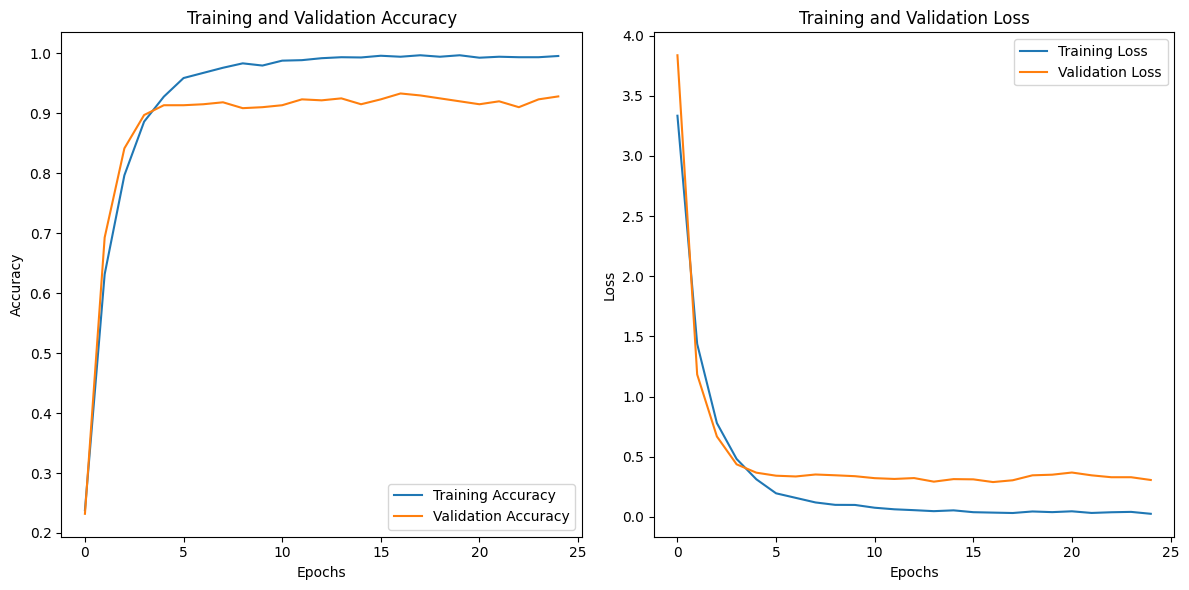

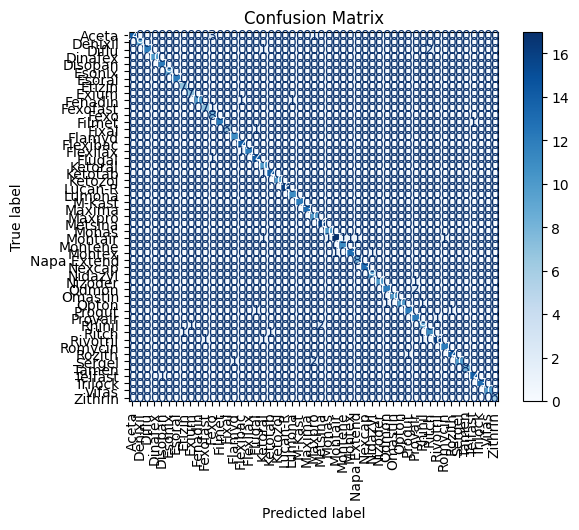


Per-Class Accuracy:
Denixil: 100.00%
Dinafex: 100.00%
Disopan: 100.00%
Esonix: 100.00%
Esoral: 100.00%
Etizin: 100.00%
Exium: 100.00%
Fexo: 100.00%
Flamyd: 100.00%
Flexibac: 100.00%
Ketoral: 100.00%
Ketozol: 100.00%
Lucan-R: 100.00%
Lumona: 100.00%
M-Kast: 100.00%
Maxima: 100.00%
Maxpro: 100.00%
Metsina: 100.00%
Monas: 100.00%
Montene: 100.00%
Napa Extend: 100.00%
Nexcap: 100.00%
Nidazyl: 100.00%
Omastin: 100.00%
Romycin: 100.00%
Tamen: 100.00%
Trilock: 100.00%
Vifas: 100.00%
Zithrin: 100.00%
Flugal: 93.33%
Ketotab: 93.33%
Rozith: 93.33%
Telfast: 93.33%
Filmet: 92.31%
Flexilax: 92.31%
Provair: 92.31%
Nizoder: 90.91%
Fexofast: 87.50%
Montex: 86.67%
Fixal: 85.71%
Odmon: 85.71%
Progut: 85.71%
Ritch: 84.62%
Rivotril: 84.21%
Fenadin: 83.33%
Opton: 83.33%
Diflu: 80.00%
Aceta: 77.78%
Sergel: 76.92%
Rhinil: 75.00%
Montair: 73.91%

Classification Report:
              precision    recall  f1-score   support

       Aceta       1.00      0.78      0.88        18
     Denixil       1.00      1.0

In [16]:
# %% Create the model
input_shape = (224, 224, 3)
model = create_vgg16_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# %% Training with early stopping
batch_size = 32
epochs = 25

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Perform 5-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(images)):
    print(f"\nStarting Fold {fold + 1}/{k}...")

    # Split the dataset into training and validation sets for this fold
    X_train, X_val = images[train_idx], images[val_idx]
    y_train, y_val = labels_categorical[train_idx], labels_categorical[val_idx]

    # Create a new VGG16 model for this fold
    model = create_vgg16_model(input_shape, num_classes)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        #callbacks=[early_stopping],
        shuffle = True,
        verbose=1
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Store the metrics
    fold_results.append({
        "fold": fold + 1,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

    # Evaluate model and display results for the current fold
    class_names = list(unique_medicines.keys())  # List of class names
    evaluate_model(model, X_val, y_val, class_names)
    
    
    # Save the final trained model
model.save('final_model.h5')
print("Final model saved to 'final_model.h5'.")

In [17]:
# Calculate average metrics across all folds
avg_loss = np.mean([result["val_loss"] for result in fold_results])
avg_accuracy = np.mean([result["val_accuracy"] for result in fold_results])

print("\nCross-Validation Results:")
for result in fold_results:
    print(f"Fold {result['fold']}: Validation Loss = {result['val_loss']:.4f}, Validation Accuracy = {result['val_accuracy']:.4f}")

print(f"\nAverage Validation Loss: {avg_loss:.4f}")
print(f"Average Validation Accuracy: {avg_accuracy:.4f}")


Cross-Validation Results:
Fold 1: Validation Loss = 0.3859, Validation Accuracy = 0.9052
Fold 2: Validation Loss = 0.3955, Validation Accuracy = 0.9167
Fold 3: Validation Loss = 0.2911, Validation Accuracy = 0.9314
Fold 4: Validation Loss = 0.2382, Validation Accuracy = 0.9346
Fold 5: Validation Loss = 0.3061, Validation Accuracy = 0.9281

Average Validation Loss: 0.3234
Average Validation Accuracy: 0.9232


In [8]:
# Function to load and preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    # Use the alias here
    img = keras_image.load_img(img_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Use a raw string for Windows paths to avoid escape issues
img_path = 'cropped_images\cropped_24.png'
input_image = preprocess_image(img_path)


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13228\3229014598.py:11: SyntaxWarning: invalid escape sequence '\c'
  img_path = 'cropped_images\cropped_24.png'


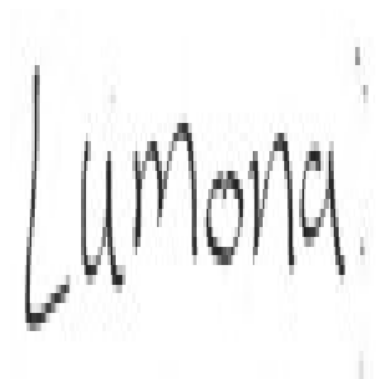

In [9]:
original_img = keras_image.load_img(img_path, target_size=(224,224))
plt.imshow(original_img)
plt.axis('off')
plt.show()

In [10]:
top_classes = [
    'Rivotril', 'Lumona', 'Lucan-R', 'Maxima', 'Ritch', 'Filmet', 'Dinafex', 'Etizin',
    'Sergel', 'Napa Extend', 'Monas', 'Fexo', 'Opton', 'Denixil', 'Ketozol', 'Tamen',
    'Telfast', 'Fenadin', 'Odmon', 'Metsina', 'Esoral', 'Omastin', 'Zithrin', 'Provair',
    'Ketotab', 'Fexofast', 'Rhinil', 'Exium', 'Flexibac', 'Progut', 'Nizoder', 'Flugal',
    'Disopan', 'Esonix', 'Trilock', 'Montair', 'Flexilax', 'M-Kast', 'Nexcap', 'Flamyd',
    'Nidazyl', 'Rozith', 'Maxpro', 'Montene', 'Diflu', 'Vifas', 'Montex', 'Ketoral',
    'Romycin', 'Fixal', 'Aceta'
]
# Load the trained model
model = load_model('final_model.h5')

# Predict the class
prediction = model.predict(input_image)
print(prediction)


# Get the class index with the highest probability
predicted_class = np.argmax(prediction, axis=1)[0]

print(predicted_class)
confidence = np.max(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 7.5842252e-21 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  8.4585155e-38 0.0000000e+00 0.0000000e+00 1.7044467e-09 2.5025547e-24
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 5.8920024e-34 0.0000000e+00
  0.0000000e+00 1.4605164e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 7.9981021e-31 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]]
30
